# Relational Knowledge Distillation - Wider Dataset

https://arxiv.org/abs/1904.05068

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import boto3
import io
import os

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss
from utils.misc_tools_rkd import best_lr_rkd, rkd_train_teacher, rkd_train_student_with_distillation, rkd_test_model
from utils.compare_tools_rkd import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison


In [2]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 240
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
beta = 0.0
patience = 7  # for early stopping

batch_size = 16
num_workers = 2

# class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
# class_labels_new = torch.tensor([i for i in range(len(class_labels))])

In [3]:
# Load WIDER dataset


train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])


trainloader, testloader  =  load_wider(train_file, test_file, class_labels, 
                                       batch_size, num_workers) 

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [4]:
# # Accessing a single batch from the DataLoader
# batch = next(iter(trainloader))
# batch

In [5]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = models.resnet50(pretrained=True)  # Keep ResNet50 as it is
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = CustomResNet18()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# Ensure the final classification layer is added to the model
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)
student_model.fc = nn.Linear(student_model.output_size, num_classes)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)


criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
torch.cuda.empty_cache()

In [8]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [9]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"


## Fina the best learning rate

100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:42<00:00,  4.63it/s]


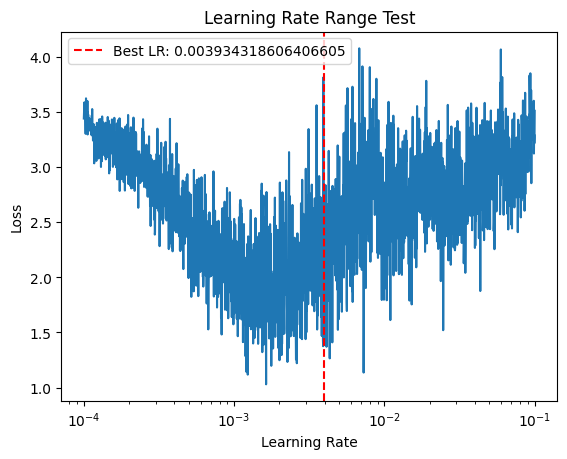

Best learning rate: 0.003934318606406605
0.003934318606406605


In [8]:
teacher_lr = best_lr_rkd(teacher_model, trainloader, criterion, 
                        teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(teacher_lr)

100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.25it/s]


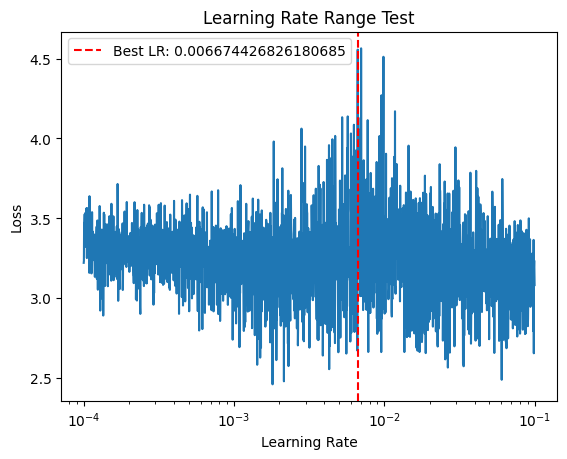

Best learning rate: 0.006674426826180685
0.006674426826180685


In [9]:
studnet_lr = best_lr_rkd(student_model, trainloader, criterion, 
                         student_optimizer, student_scheduler, device, num_epochs=3)  
print(studnet_lr)

In [10]:
teacher_lr = 0.003934318606406605
student_lr = 0.006674426826180685

In [11]:
# Ensure the final classification layer is added to the model
# num_class = 30
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)
student_model.fc = nn.Linear(student_model.output_size, num_classes)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=student_lr, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_lr, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Training Teacher and Student Models

In [12]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
rkd_train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)


 13%|█████████▌                                                              | 100/754 [00:22<02:10,  5.02it/s]

[1, 100] loss: 3.345


 27%|███████████████████                                                     | 200/754 [00:44<01:55,  4.80it/s]

[1, 200] loss: 3.275


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:37,  4.65it/s]

[1, 300] loss: 3.240


 53%|██████████████████████████████████████▎                                 | 401/754 [01:27<01:24,  4.17it/s]

[1, 400] loss: 3.180


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:49,  5.14it/s]

[1, 500] loss: 3.147


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:30,  5.06it/s]

[1, 600] loss: 3.147


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:11,  4.80it/s]

[1, 700] loss: 3.102


 13%|█████████▋                                                              | 101/754 [00:22<02:21,  4.62it/s]

[2, 100] loss: 3.061


 27%|███████████████████▏                                                    | 201/754 [00:44<01:55,  4.78it/s]

[2, 200] loss: 3.036


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:31,  4.95it/s]

[2, 300] loss: 3.001


 53%|██████████████████████████████████████▎                                 | 401/754 [01:26<01:15,  4.67it/s]

[2, 400] loss: 2.977


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:49<00:51,  4.94it/s]

[2, 500] loss: 2.919


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:28,  5.28it/s]

[2, 600] loss: 2.964


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:10,  5.19it/s]

[2, 700] loss: 2.926


 13%|█████████▋                                                              | 101/754 [00:22<02:10,  5.01it/s]

[3, 100] loss: 2.872


 27%|███████████████████                                                     | 200/754 [00:44<02:02,  4.51it/s]

[3, 200] loss: 2.872


 40%|████████████████████████████▋                                           | 300/754 [01:07<01:28,  5.11it/s]

[3, 300] loss: 2.862


 53%|██████████████████████████████████████▏                                 | 400/754 [01:29<01:18,  4.51it/s]

[3, 400] loss: 2.823


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:50<00:49,  5.15it/s]

[3, 500] loss: 2.812


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:13<00:33,  4.53it/s]

[3, 600] loss: 2.818


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:36<00:12,  4.40it/s]

[3, 700] loss: 2.755


 13%|█████████▌                                                              | 100/754 [00:23<02:10,  5.02it/s]

[4, 100] loss: 2.794


 27%|███████████████████                                                     | 200/754 [00:45<02:06,  4.37it/s]

[4, 200] loss: 2.784


 40%|████████████████████████████▋                                           | 300/754 [01:09<01:43,  4.39it/s]

[4, 300] loss: 2.742


 53%|██████████████████████████████████████▏                                 | 400/754 [01:32<01:08,  5.18it/s]

[4, 400] loss: 2.733


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:56<00:51,  4.90it/s]

[4, 500] loss: 2.728


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:18<00:33,  4.63it/s]

[4, 600] loss: 2.697


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:40<00:10,  5.14it/s]

[4, 700] loss: 2.704


 13%|█████████▋                                                              | 101/754 [00:23<02:24,  4.52it/s]

[5, 100] loss: 2.683


 27%|███████████████████                                                     | 200/754 [00:47<01:49,  5.08it/s]

[5, 200] loss: 2.643


 40%|████████████████████████████▋                                           | 300/754 [01:10<01:54,  3.95it/s]

[5, 300] loss: 2.603


 53%|██████████████████████████████████████▎                                 | 401/754 [01:34<01:15,  4.66it/s]

[5, 400] loss: 2.621


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:58<00:59,  4.23it/s]

[5, 500] loss: 2.586


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:22<00:34,  4.44it/s]

[5, 600] loss: 2.650


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:46<00:12,  4.43it/s]

[5, 700] loss: 2.627


 13%|█████████▌                                                              | 100/754 [00:22<02:08,  5.09it/s]

[6, 100] loss: 2.524


 27%|███████████████████                                                     | 200/754 [00:45<02:12,  4.17it/s]

[6, 200] loss: 2.573


 40%|████████████████████████████▋                                           | 301/754 [01:09<01:37,  4.64it/s]

[6, 300] loss: 2.563


 53%|██████████████████████████████████████▏                                 | 400/754 [01:32<01:13,  4.80it/s]

[6, 400] loss: 2.472


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:55<00:52,  4.82it/s]

[6, 500] loss: 2.467


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:18<00:30,  5.04it/s]

[6, 600] loss: 2.496


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:41<00:10,  5.03it/s]

[6, 700] loss: 2.480


 13%|█████████▋                                                              | 101/754 [00:24<02:26,  4.45it/s]

[7, 100] loss: 2.411


 27%|███████████████████                                                     | 200/754 [00:46<02:07,  4.34it/s]

[7, 200] loss: 2.368


 40%|████████████████████████████▋                                           | 300/754 [01:09<01:32,  4.92it/s]

[7, 300] loss: 2.437


 53%|██████████████████████████████████████▎                                 | 401/754 [01:31<01:12,  4.90it/s]

[7, 400] loss: 2.424


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:54<00:56,  4.46it/s]

[7, 500] loss: 2.367


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:17<00:35,  4.31it/s]

[7, 600] loss: 2.328


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:41<00:12,  4.36it/s]

[7, 700] loss: 2.364


 13%|█████████▋                                                              | 101/754 [00:23<02:27,  4.44it/s]

[8, 100] loss: 2.307


 27%|███████████████████▏                                                    | 201/754 [00:46<02:10,  4.24it/s]

[8, 200] loss: 2.275


 40%|████████████████████████████▋                                           | 301/754 [01:09<01:33,  4.85it/s]

[8, 300] loss: 2.312


 53%|██████████████████████████████████████▎                                 | 401/754 [01:32<01:13,  4.80it/s]

[8, 400] loss: 2.277


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:56<00:56,  4.50it/s]

[8, 500] loss: 2.271


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:19<00:36,  4.25it/s]

[8, 600] loss: 2.278


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:42<00:12,  4.20it/s]

[8, 700] loss: 2.240


 13%|█████████▋                                                              | 101/754 [00:23<02:37,  4.15it/s]

[9, 100] loss: 2.181


 27%|███████████████████                                                     | 200/754 [00:45<02:00,  4.60it/s]

[9, 200] loss: 2.137


 40%|████████████████████████████▋                                           | 300/754 [01:08<01:42,  4.45it/s]

[9, 300] loss: 2.161


 53%|██████████████████████████████████████▎                                 | 401/754 [01:31<01:16,  4.63it/s]

[9, 400] loss: 2.169


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:54<00:56,  4.53it/s]

[9, 500] loss: 2.138


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:17<00:30,  5.03it/s]

[9, 600] loss: 2.159


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:41<00:12,  4.37it/s]

[9, 700] loss: 2.198


 13%|█████████▌                                                              | 100/754 [00:23<02:17,  4.76it/s]

[10, 100] loss: 2.032


 27%|███████████████████                                                     | 200/754 [00:46<02:01,  4.55it/s]

[10, 200] loss: 2.027


 40%|████████████████████████████▋                                           | 300/754 [01:10<01:41,  4.46it/s]

[10, 300] loss: 2.074


 53%|██████████████████████████████████████▎                                 | 401/754 [01:34<01:09,  5.06it/s]

[10, 400] loss: 2.083


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:57<00:47,  5.29it/s]

[10, 500] loss: 2.067


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:19<00:31,  4.80it/s]

[10, 600] loss: 2.055


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:41<00:10,  5.14it/s]

[10, 700] loss: 2.017


 13%|█████████▌                                                              | 100/754 [00:23<02:15,  4.82it/s]

[11, 100] loss: 1.851


 27%|███████████████████▏                                                    | 201/754 [00:46<02:00,  4.58it/s]

[11, 200] loss: 2.030


 40%|████████████████████████████▋                                           | 300/754 [01:10<01:43,  4.38it/s]

[11, 300] loss: 1.941


 53%|██████████████████████████████████████▎                                 | 401/754 [01:34<01:19,  4.43it/s]

[11, 400] loss: 1.956


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:58<00:55,  4.53it/s]

[11, 500] loss: 1.907


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:20<00:29,  5.30it/s]

[11, 600] loss: 1.957


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:43<00:11,  4.62it/s]

[11, 700] loss: 1.941


 13%|█████████▋                                                              | 101/754 [00:24<02:00,  5.42it/s]

[12, 100] loss: 1.826


 27%|███████████████████▏                                                    | 201/754 [00:48<01:48,  5.09it/s]

[12, 200] loss: 1.834


 40%|████████████████████████████▋                                           | 300/754 [01:11<01:31,  4.97it/s]

[12, 300] loss: 1.876


 53%|██████████████████████████████████████▎                                 | 401/754 [01:34<01:15,  4.66it/s]

[12, 400] loss: 1.853


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:56<00:49,  5.11it/s]

[12, 500] loss: 1.804


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:19<00:35,  4.30it/s]

[12, 600] loss: 1.862


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:43<00:13,  4.00it/s]

[12, 700] loss: 1.828


 13%|█████████▌                                                              | 100/754 [00:24<02:28,  4.41it/s]

[13, 100] loss: 1.696


 27%|███████████████████▏                                                    | 201/754 [00:48<02:04,  4.45it/s]

[13, 200] loss: 1.734


 40%|████████████████████████████▋                                           | 300/754 [01:11<01:39,  4.56it/s]

[13, 300] loss: 1.701


 53%|██████████████████████████████████████▎                                 | 401/754 [01:36<01:15,  4.65it/s]

[13, 400] loss: 1.762


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:59<00:58,  4.36it/s]

[13, 500] loss: 1.722


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:22<00:34,  4.48it/s]

[13, 600] loss: 1.749


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:45<00:10,  5.02it/s]

[13, 700] loss: 1.759


 13%|█████████▋                                                              | 101/754 [00:23<02:17,  4.76it/s]

[14, 100] loss: 1.596


 27%|███████████████████▏                                                    | 201/754 [00:44<01:43,  5.33it/s]

[14, 200] loss: 1.623


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:21,  5.55it/s]

[14, 300] loss: 1.646


 53%|██████████████████████████████████████▎                                 | 401/754 [01:27<01:01,  5.73it/s]

[14, 400] loss: 1.635


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:50,  5.07it/s]

[14, 500] loss: 1.614


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:32,  4.66it/s]

[14, 600] loss: 1.668


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:33<00:11,  4.60it/s]

[14, 700] loss: 1.654


 13%|█████████▌                                                              | 100/754 [00:23<02:15,  4.84it/s]

[15, 100] loss: 1.450


 27%|███████████████████▏                                                    | 201/754 [00:45<01:45,  5.23it/s]

[15, 200] loss: 1.525


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:39,  4.56it/s]

[15, 300] loss: 1.497


 53%|██████████████████████████████████████▏                                 | 400/754 [01:30<01:12,  4.91it/s]

[15, 400] loss: 1.488


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:59,  4.27it/s]

[15, 500] loss: 1.462


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:15<00:30,  5.05it/s]

[15, 600] loss: 1.614


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:37<00:11,  4.61it/s]

[15, 700] loss: 1.603


 13%|█████████▋                                                              | 101/754 [00:22<02:25,  4.48it/s]

[16, 100] loss: 1.352


 27%|███████████████████                                                     | 200/754 [00:44<02:02,  4.52it/s]

[16, 200] loss: 1.407


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:26,  5.24it/s]

[16, 300] loss: 1.359


 53%|██████████████████████████████████████▎                                 | 401/754 [01:29<01:14,  4.75it/s]

[16, 400] loss: 1.383


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<01:02,  4.03it/s]

[16, 500] loss: 1.456


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:15<00:35,  4.30it/s]

[16, 600] loss: 1.469


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:38<00:12,  4.48it/s]

[16, 700] loss: 1.496


 13%|█████████▋                                                              | 101/754 [00:22<02:19,  4.69it/s]

[17, 100] loss: 1.212


 27%|███████████████████▏                                                    | 201/754 [00:44<01:52,  4.89it/s]

[17, 200] loss: 1.344


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:32,  4.92it/s]

[17, 300] loss: 1.359


 53%|██████████████████████████████████████▎                                 | 401/754 [01:29<01:18,  4.48it/s]

[17, 400] loss: 1.296


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:46,  5.44it/s]

[17, 500] loss: 1.397


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:13<00:32,  4.79it/s]

[17, 600] loss: 1.375


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:36<00:09,  5.34it/s]

[17, 700] loss: 1.437


 13%|█████████▋                                                              | 101/754 [00:22<02:20,  4.65it/s]

[18, 100] loss: 1.104


 27%|███████████████████                                                     | 200/754 [00:45<02:03,  4.50it/s]

[18, 200] loss: 1.223


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:31,  4.95it/s]

[18, 300] loss: 1.183


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:19,  4.46it/s]

[18, 400] loss: 1.245


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:50,  5.07it/s]

[18, 500] loss: 1.354


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:15<00:33,  4.63it/s]

[18, 600] loss: 1.255


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:38<00:10,  5.18it/s]

[18, 700] loss: 1.302


 13%|█████████▌                                                              | 100/754 [00:23<02:16,  4.80it/s]

[19, 100] loss: 1.100


 27%|███████████████████                                                     | 200/754 [00:45<01:47,  5.15it/s]

[19, 200] loss: 1.138


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:46,  4.24it/s]

[19, 300] loss: 1.110


 53%|██████████████████████████████████████▎                                 | 401/754 [01:29<01:12,  4.87it/s]

[19, 400] loss: 1.138


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:51<00:55,  4.56it/s]

[19, 500] loss: 1.162


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:35,  4.30it/s]

[19, 600] loss: 1.259


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:35<00:11,  4.68it/s]

[19, 700] loss: 1.221


 13%|█████████▋                                                              | 101/754 [00:23<02:22,  4.58it/s]

[20, 100] loss: 1.027


 27%|███████████████████                                                     | 200/754 [00:45<02:00,  4.59it/s]

[20, 200] loss: 1.022


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:51,  4.05it/s]

[20, 300] loss: 1.020


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:20,  4.38it/s]

[20, 400] loss: 1.128


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:53,  4.72it/s]

[20, 500] loss: 1.134


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:15<00:32,  4.70it/s]

[20, 600] loss: 1.152


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:37<00:11,  4.79it/s]

[20, 700] loss: 1.128


 13%|█████████▋                                                              | 101/754 [00:23<02:08,  5.10it/s]

[21, 100] loss: 0.824


 27%|███████████████████▏                                                    | 201/754 [00:46<01:53,  4.88it/s]

[21, 200] loss: 0.960


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:22,  5.52it/s]

[21, 300] loss: 0.947


 53%|██████████████████████████████████████▏                                 | 400/754 [01:30<01:15,  4.67it/s]

[21, 400] loss: 1.072


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<01:01,  4.12it/s]

[21, 500] loss: 1.019


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:14<00:33,  4.55it/s]

[21, 600] loss: 1.064


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:37<00:14,  3.60it/s]

[21, 700] loss: 1.039


 13%|█████████▋                                                              | 101/754 [00:22<02:16,  4.80it/s]

[22, 100] loss: 0.837


 27%|███████████████████▏                                                    | 201/754 [00:45<02:03,  4.48it/s]

[22, 200] loss: 0.848


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:32,  4.89it/s]

[22, 300] loss: 0.924


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:13,  4.81it/s]

[22, 400] loss: 0.935


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:53<00:55,  4.57it/s]

[22, 500] loss: 0.981


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:15<00:34,  4.52it/s]

[22, 600] loss: 1.028


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:37<00:11,  4.43it/s]

[22, 700] loss: 1.003


 13%|█████████▋                                                              | 101/754 [00:21<02:12,  4.92it/s]

[23, 100] loss: 0.824


 27%|███████████████████▏                                                    | 201/754 [00:43<01:35,  5.81it/s]

[23, 200] loss: 0.792


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:22,  5.52it/s]

[23, 300] loss: 0.852


 53%|██████████████████████████████████████▎                                 | 401/754 [01:25<01:14,  4.71it/s]

[23, 400] loss: 0.877


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:53,  4.76it/s]

[23, 500] loss: 0.828


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:08<00:34,  4.50it/s]

[23, 600] loss: 0.890


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:30<00:11,  4.79it/s]

[23, 700] loss: 0.977


 13%|█████████▋                                                              | 101/754 [00:22<02:19,  4.68it/s]

[24, 100] loss: 0.751


 27%|███████████████████▏                                                    | 201/754 [00:43<01:45,  5.24it/s]

[24, 200] loss: 0.772


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:39,  4.56it/s]

[24, 300] loss: 0.824


 53%|██████████████████████████████████████▎                                 | 401/754 [01:26<01:10,  5.04it/s]

[24, 400] loss: 0.734


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:43,  5.77it/s]

[24, 500] loss: 0.808


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:34,  4.39it/s]

[24, 600] loss: 0.851


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:10,  5.00it/s]

[24, 700] loss: 0.879


 13%|█████████▋                                                              | 101/754 [00:22<02:26,  4.46it/s]

[25, 100] loss: 0.661


 27%|███████████████████                                                     | 200/754 [00:44<01:57,  4.70it/s]

[25, 200] loss: 0.675


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:46,  4.25it/s]

[25, 300] loss: 0.707


 53%|██████████████████████████████████████▎                                 | 401/754 [01:27<01:14,  4.75it/s]

[25, 400] loss: 0.717


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:53,  4.77it/s]

[25, 500] loss: 0.798


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:31,  4.89it/s]

[25, 600] loss: 0.811


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:32<00:12,  4.39it/s]

[25, 700] loss: 0.789


 13%|█████████▋                                                              | 101/754 [00:22<01:55,  5.63it/s]

[26, 100] loss: 0.589


 27%|███████████████████▏                                                    | 201/754 [00:43<01:58,  4.68it/s]

[26, 200] loss: 0.654


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:29,  5.07it/s]

[26, 300] loss: 0.676


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:07,  5.24it/s]

[26, 400] loss: 0.709


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:48<01:02,  4.05it/s]

[26, 500] loss: 0.756


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:09<00:33,  4.54it/s]

[26, 600] loss: 0.728


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:31<00:12,  4.19it/s]

[26, 700] loss: 0.747


 13%|█████████▌                                                              | 100/754 [00:21<01:59,  5.47it/s]

[27, 100] loss: 0.508


 27%|███████████████████▏                                                    | 201/754 [00:44<02:31,  3.65it/s]

[27, 200] loss: 0.579


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:29,  5.05it/s]

[27, 300] loss: 0.564


 53%|██████████████████████████████████████▏                                 | 400/754 [01:28<01:22,  4.28it/s]

[27, 400] loss: 0.608


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:55,  4.61it/s]

[27, 500] loss: 0.629


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:10<00:30,  4.98it/s]

[27, 600] loss: 0.687


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:32<00:10,  5.14it/s]

[27, 700] loss: 0.732


 13%|█████████▌                                                              | 100/754 [00:22<02:24,  4.52it/s]

[28, 100] loss: 0.553


 27%|███████████████████▏                                                    | 201/754 [00:44<01:53,  4.85it/s]

[28, 200] loss: 0.575


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:24,  5.38it/s]

[28, 300] loss: 0.580


 53%|██████████████████████████████████████▎                                 | 401/754 [01:27<01:06,  5.33it/s]

[28, 400] loss: 0.648


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:47,  5.33it/s]

[28, 500] loss: 0.666


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:09<00:33,  4.57it/s]

[28, 600] loss: 0.586


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:31<00:10,  5.24it/s]

[28, 700] loss: 0.622


 13%|█████████▋                                                              | 101/754 [00:22<02:15,  4.83it/s]

[29, 100] loss: 0.523


 27%|███████████████████▏                                                    | 201/754 [00:43<02:05,  4.42it/s]

[29, 200] loss: 0.485


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:41,  4.46it/s]

[29, 300] loss: 0.516


 53%|██████████████████████████████████████▏                                 | 400/754 [01:25<01:16,  4.64it/s]

[29, 400] loss: 0.546


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:46<00:50,  5.08it/s]

[29, 500] loss: 0.531


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:08<00:31,  4.89it/s]

[29, 600] loss: 0.563


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:30<00:11,  4.79it/s]

[29, 700] loss: 0.642


 13%|█████████▌                                                              | 100/754 [00:21<02:16,  4.81it/s]

[30, 100] loss: 0.467


 27%|███████████████████▏                                                    | 201/754 [00:43<02:00,  4.61it/s]

[30, 200] loss: 0.492


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:39,  4.57it/s]

[30, 300] loss: 0.480


 53%|██████████████████████████████████████▎                                 | 401/754 [01:27<01:06,  5.30it/s]

[30, 400] loss: 0.476


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:48<00:50,  5.04it/s]

[30, 500] loss: 0.559


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:09<00:30,  5.04it/s]

[30, 600] loss: 0.553


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:31<00:10,  4.86it/s]

[30, 700] loss: 0.539


 13%|█████████▋                                                              | 101/754 [00:22<02:22,  4.59it/s]

[31, 100] loss: 0.370


 27%|███████████████████                                                     | 200/754 [00:43<01:49,  5.07it/s]

[31, 200] loss: 0.287


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:38,  4.63it/s]

[31, 300] loss: 0.344


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:18,  4.54it/s]

[31, 400] loss: 0.282


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:47<00:50,  5.00it/s]

[31, 500] loss: 0.265


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:08<00:30,  5.07it/s]

[31, 600] loss: 0.282


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:29<00:12,  4.44it/s]

[31, 700] loss: 0.244


 13%|█████████▋                                                              | 101/754 [00:21<02:09,  5.04it/s]

[32, 100] loss: 0.255


 27%|███████████████████▏                                                    | 201/754 [00:43<01:44,  5.29it/s]

[32, 200] loss: 0.207


 40%|████████████████████████████▋                                           | 301/754 [01:04<01:40,  4.50it/s]

[32, 300] loss: 0.233


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:16,  4.62it/s]

[32, 400] loss: 0.223


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:47<00:53,  4.74it/s]

[32, 500] loss: 0.217


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:08<00:34,  4.49it/s]

[32, 600] loss: 0.222


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:30<00:11,  4.87it/s]

[32, 700] loss: 0.253


 13%|█████████▋                                                              | 101/754 [00:22<02:11,  4.97it/s]

[33, 100] loss: 0.197


 27%|███████████████████                                                     | 200/754 [00:43<01:46,  5.18it/s]

[33, 200] loss: 0.198


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:33,  4.84it/s]

[33, 300] loss: 0.205


 53%|██████████████████████████████████████▎                                 | 401/754 [01:26<01:10,  5.01it/s]

[33, 400] loss: 0.212


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:47<00:57,  4.41it/s]

[33, 500] loss: 0.211


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:09<00:30,  4.94it/s]

[33, 600] loss: 0.200


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:30<00:11,  4.69it/s]

[33, 700] loss: 0.215


 13%|█████████▌                                                              | 100/754 [00:21<02:20,  4.67it/s]

[34, 100] loss: 0.204


 27%|███████████████████                                                     | 200/754 [00:43<01:56,  4.75it/s]

[34, 200] loss: 0.166


 40%|████████████████████████████▋                                           | 300/754 [01:05<01:34,  4.83it/s]

[34, 300] loss: 0.168


 53%|██████████████████████████████████████▏                                 | 400/754 [01:28<01:21,  4.34it/s]

[34, 400] loss: 0.203


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:50<00:48,  5.18it/s]

[34, 500] loss: 0.166


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:11<00:33,  4.60it/s]

[34, 600] loss: 0.160


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:34<00:10,  5.28it/s]

[34, 700] loss: 0.169


 13%|█████████▌                                                              | 100/754 [00:23<02:14,  4.85it/s]

[35, 100] loss: 0.146


 27%|███████████████████                                                     | 200/754 [00:45<01:52,  4.92it/s]

[35, 200] loss: 0.158


 40%|████████████████████████████▋                                           | 300/754 [01:07<01:40,  4.50it/s]

[35, 300] loss: 0.174


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:29,  3.95it/s]

[35, 400] loss: 0.147


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:54,  4.64it/s]

[35, 500] loss: 0.154


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:15<00:32,  4.77it/s]

[35, 600] loss: 0.162


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:38<00:11,  4.51it/s]

[35, 700] loss: 0.172


 13%|█████████▋                                                              | 101/754 [00:23<02:15,  4.82it/s]

[36, 100] loss: 0.146


 27%|███████████████████▏                                                    | 201/754 [00:44<01:46,  5.20it/s]

[36, 200] loss: 0.123


 40%|████████████████████████████▋                                           | 300/754 [01:06<01:36,  4.69it/s]

[36, 300] loss: 0.164


 53%|██████████████████████████████████████▏                                 | 400/754 [01:29<01:23,  4.25it/s]

[36, 400] loss: 0.154


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:49,  5.13it/s]

[36, 500] loss: 0.147


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:14<00:30,  4.97it/s]

[36, 600] loss: 0.142


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:36<00:10,  4.83it/s]

[36, 700] loss: 0.130


 13%|█████████▌                                                              | 100/754 [00:22<02:09,  5.06it/s]

[37, 100] loss: 0.132


 27%|███████████████████▏                                                    | 201/754 [00:45<01:52,  4.90it/s]

[37, 200] loss: 0.159


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:30,  5.02it/s]

[37, 300] loss: 0.147


 53%|██████████████████████████████████████▏                                 | 400/754 [01:30<01:16,  4.65it/s]

[37, 400] loss: 0.142


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<00:51,  4.91it/s]

[37, 500] loss: 0.137


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:14<00:28,  5.33it/s]

[37, 600] loss: 0.121


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:36<00:10,  5.10it/s]

[37, 700] loss: 0.121


 13%|█████████▌                                                              | 100/754 [00:22<02:38,  4.13it/s]

[38, 100] loss: 0.129


 27%|███████████████████                                                     | 200/754 [00:45<02:00,  4.59it/s]

[38, 200] loss: 0.132


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:32,  4.91it/s]

[38, 300] loss: 0.135


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:17,  4.57it/s]

[38, 400] loss: 0.136


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:52<00:53,  4.78it/s]

[38, 500] loss: 0.152


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:14<00:27,  5.60it/s]

[38, 600] loss: 0.139


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:36<00:10,  5.00it/s]

[38, 700] loss: 0.125


 13%|█████████▌                                                              | 100/754 [00:22<02:14,  4.87it/s]

[39, 100] loss: 0.109


 27%|███████████████████                                                     | 200/754 [00:44<01:52,  4.91it/s]

[39, 200] loss: 0.122


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:47,  4.22it/s]

[39, 300] loss: 0.113


 53%|██████████████████████████████████████▏                                 | 400/754 [01:28<01:12,  4.89it/s]

[39, 400] loss: 0.123


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:54,  4.70it/s]

[39, 500] loss: 0.122


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:14<00:34,  4.39it/s]

[39, 600] loss: 0.119


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:37<00:11,  4.62it/s]

[39, 700] loss: 0.138


 13%|█████████▌                                                              | 100/754 [00:22<02:20,  4.67it/s]

[40, 100] loss: 0.128


 27%|███████████████████▏                                                    | 201/754 [00:44<01:53,  4.85it/s]

[40, 200] loss: 0.133


 40%|████████████████████████████▋                                           | 300/754 [01:07<01:46,  4.28it/s]

[40, 300] loss: 0.133


 53%|██████████████████████████████████████▏                                 | 400/754 [01:29<01:18,  4.50it/s]

[40, 400] loss: 0.112


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<00:55,  4.60it/s]

[40, 500] loss: 0.140


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:29,  5.17it/s]

[40, 600] loss: 0.143


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:35<00:11,  4.86it/s]

[40, 700] loss: 0.114


 13%|█████████▋                                                              | 101/754 [00:22<02:28,  4.41it/s]

[41, 100] loss: 0.112


 27%|███████████████████                                                     | 200/754 [00:43<02:07,  4.35it/s]

[41, 200] loss: 0.114


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:40,  4.51it/s]

[41, 300] loss: 0.119


 53%|██████████████████████████████████████▏                                 | 400/754 [01:28<01:18,  4.52it/s]

[41, 400] loss: 0.123


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:55,  4.60it/s]

[41, 500] loss: 0.118


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:31,  4.78it/s]

[41, 600] loss: 0.112


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:35<00:11,  4.74it/s]

[41, 700] loss: 0.133


 13%|█████████▋                                                              | 101/754 [00:22<02:12,  4.92it/s]

[42, 100] loss: 0.136


 27%|███████████████████                                                     | 200/754 [00:45<02:03,  4.48it/s]

[42, 200] loss: 0.136


 40%|████████████████████████████▋                                           | 300/754 [01:07<01:30,  5.04it/s]

[42, 300] loss: 0.114


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:26,  4.06it/s]

[42, 400] loss: 0.106


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:53<00:49,  5.16it/s]

[42, 500] loss: 0.112


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:14<00:35,  4.37it/s]

[42, 600] loss: 0.136


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:37<00:10,  4.96it/s]

[42, 700] loss: 0.101


 13%|█████████▋                                                              | 101/754 [00:22<02:11,  4.97it/s]

[43, 100] loss: 0.135


 27%|███████████████████▏                                                    | 201/754 [00:44<01:54,  4.83it/s]

[43, 200] loss: 0.119


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:42,  4.41it/s]

[43, 300] loss: 0.103


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:19,  4.46it/s]

[43, 400] loss: 0.122


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:54,  4.69it/s]

[43, 500] loss: 0.117


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:13<00:30,  5.12it/s]

[43, 600] loss: 0.116


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:36<00:11,  4.63it/s]

[43, 700] loss: 0.122


 13%|█████████▋                                                              | 101/754 [00:22<02:33,  4.26it/s]

[44, 100] loss: 0.101


 27%|███████████████████                                                     | 200/754 [00:44<01:48,  5.09it/s]

[44, 200] loss: 0.106


 40%|████████████████████████████▋                                           | 301/754 [01:06<01:25,  5.31it/s]

[44, 300] loss: 0.117


 53%|██████████████████████████████████████▏                                 | 400/754 [01:27<01:15,  4.68it/s]

[44, 400] loss: 0.120


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:49<00:44,  5.66it/s]

[44, 500] loss: 0.116


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:12<00:32,  4.78it/s]

[44, 600] loss: 0.106


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:34<00:11,  4.63it/s]

[44, 700] loss: 0.095


 13%|█████████▋                                                              | 101/754 [00:23<02:30,  4.35it/s]

[45, 100] loss: 0.119


 27%|███████████████████                                                     | 200/754 [00:45<02:04,  4.46it/s]

[45, 200] loss: 0.094


 40%|████████████████████████████▋                                           | 300/754 [01:07<01:31,  4.94it/s]

[45, 300] loss: 0.105


 53%|██████████████████████████████████████▎                                 | 401/754 [01:30<01:22,  4.29it/s]

[45, 400] loss: 0.107


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<00:58,  4.36it/s]

[45, 500] loss: 0.102


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:14<00:32,  4.72it/s]

[45, 600] loss: 0.095


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:37<00:10,  5.18it/s]

[45, 700] loss: 0.080


 13%|█████████▌                                                              | 100/754 [00:22<02:25,  4.49it/s]

[46, 100] loss: 0.087


 27%|███████████████████▏                                                    | 201/754 [00:45<01:48,  5.10it/s]

[46, 200] loss: 0.105


 40%|████████████████████████████▋                                           | 301/754 [01:07<01:38,  4.60it/s]

[46, 300] loss: 0.111


 53%|██████████████████████████████████████▎                                 | 401/754 [01:29<01:15,  4.67it/s]

[46, 400] loss: 0.113


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:48,  5.20it/s]

[46, 500] loss: 0.110


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:31,  4.86it/s]

[46, 600] loss: 0.099


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:35<00:09,  5.47it/s]

[46, 700] loss: 0.095


 13%|█████████▋                                                              | 101/754 [00:23<02:47,  3.91it/s]

[47, 100] loss: 0.103


 27%|███████████████████                                                     | 200/754 [00:46<01:55,  4.79it/s]

[47, 200] loss: 0.102


 40%|████████████████████████████▋                                           | 300/754 [01:08<01:32,  4.88it/s]

[47, 300] loss: 0.113


 53%|██████████████████████████████████████▏                                 | 400/754 [01:29<01:19,  4.47it/s]

[47, 400] loss: 0.102


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:51<00:48,  5.19it/s]

[47, 500] loss: 0.101


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:13<00:34,  4.46it/s]

[47, 600] loss: 0.097


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:35<00:11,  4.61it/s]

[47, 700] loss: 0.105


 13%|█████████▌                                                              | 100/754 [00:22<02:13,  4.91it/s]

[48, 100] loss: 0.082


 27%|███████████████████▏                                                    | 201/754 [00:44<01:45,  5.25it/s]

[48, 200] loss: 0.082


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:39,  4.54it/s]

[48, 300] loss: 0.091


 53%|██████████████████████████████████████▏                                 | 400/754 [01:27<01:15,  4.70it/s]

[48, 400] loss: 0.100


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:49<00:47,  5.36it/s]

[48, 500] loss: 0.102


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:11<00:30,  5.13it/s]

[48, 600] loss: 0.087


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:33<00:11,  4.46it/s]

[48, 700] loss: 0.101


 13%|█████████▋                                                              | 101/754 [00:22<02:13,  4.90it/s]

[49, 100] loss: 0.088


 27%|███████████████████                                                     | 200/754 [00:44<02:06,  4.39it/s]

[49, 200] loss: 0.089


 40%|████████████████████████████▋                                           | 300/754 [01:06<01:24,  5.37it/s]

[49, 300] loss: 0.097


 53%|██████████████████████████████████████▏                                 | 400/754 [01:29<01:19,  4.43it/s]

[49, 400] loss: 0.086


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:51<00:49,  5.08it/s]

[49, 500] loss: 0.081


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:29,  5.10it/s]

[49, 600] loss: 0.099


 93%|██████████████████████████████████████████████████████████████████▉     | 701/754 [02:34<00:10,  4.86it/s]

[49, 700] loss: 0.091


 13%|█████████▌                                                              | 100/754 [00:21<02:01,  5.36it/s]

[50, 100] loss: 0.093


 27%|███████████████████▏                                                    | 201/754 [00:42<01:37,  5.67it/s]

[50, 200] loss: 0.088


 40%|████████████████████████████▋                                           | 300/754 [01:03<01:33,  4.87it/s]

[50, 300] loss: 0.096


 53%|██████████████████████████████████████▏                                 | 400/754 [01:25<01:17,  4.56it/s]

[50, 400] loss: 0.068


 66%|███████████████████████████████████████████████▋                        | 500/754 [01:46<00:56,  4.50it/s]

[50, 500] loss: 0.084


 80%|█████████████████████████████████████████████████████████▎              | 600/754 [02:08<00:32,  4.77it/s]

[50, 600] loss: 0.090


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:30<00:11,  4.89it/s]

[50, 700] loss: 0.088


 13%|█████████▌                                                              | 100/754 [00:22<02:03,  5.28it/s]

[51, 100] loss: 0.071


 27%|███████████████████▏                                                    | 201/754 [00:44<01:47,  5.15it/s]

[51, 200] loss: 0.076


 40%|████████████████████████████▋                                           | 301/754 [01:05<01:41,  4.45it/s]

[51, 300] loss: 0.089


 53%|██████████████████████████████████████▏                                 | 400/754 [01:26<01:15,  4.72it/s]

[51, 400] loss: 0.091


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:48<00:49,  5.16it/s]

[51, 500] loss: 0.097


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:09<00:32,  4.77it/s]

[51, 600] loss: 0.093


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:30<00:10,  5.16it/s]

[51, 700] loss: 0.082


 13%|█████████▋                                                              | 101/754 [00:23<02:32,  4.27it/s]

[52, 100] loss: 0.103


 27%|███████████████████                                                     | 200/754 [00:45<02:00,  4.60it/s]

[52, 200] loss: 0.086


 40%|████████████████████████████▋                                           | 301/754 [01:08<01:36,  4.68it/s]

[52, 300] loss: 0.092


 53%|██████████████████████████████████████▏                                 | 400/754 [01:30<01:08,  5.16it/s]

[52, 400] loss: 0.075


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:52<00:54,  4.62it/s]

[52, 500] loss: 0.066


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:33,  4.57it/s]

[52, 600] loss: 0.082


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:34<00:10,  5.12it/s]

[52, 700] loss: 0.075


 13%|█████████▌                                                              | 100/754 [00:22<02:02,  5.36it/s]

[53, 100] loss: 0.079


 27%|███████████████████                                                     | 200/754 [00:44<02:06,  4.38it/s]

[53, 200] loss: 0.088


 40%|████████████████████████████▋                                           | 300/754 [01:04<01:35,  4.75it/s]

[53, 300] loss: 0.082


 53%|██████████████████████████████████████▎                                 | 401/754 [01:26<01:11,  4.93it/s]

[53, 400] loss: 0.086


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:48<00:56,  4.48it/s]

[53, 500] loss: 0.093


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:09<00:32,  4.68it/s]

[53, 600] loss: 0.082


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:30<00:12,  4.48it/s]

[53, 700] loss: 0.083


 13%|█████████▌                                                              | 100/754 [00:22<02:23,  4.55it/s]

[54, 100] loss: 0.076


 27%|███████████████████▏                                                    | 201/754 [00:44<01:40,  5.50it/s]

[54, 200] loss: 0.098


 40%|████████████████████████████▋                                           | 300/754 [01:06<01:26,  5.27it/s]

[54, 300] loss: 0.082


 53%|██████████████████████████████████████▎                                 | 401/754 [01:28<01:12,  4.89it/s]

[54, 400] loss: 0.068


 66%|███████████████████████████████████████████████▊                        | 501/754 [01:50<00:54,  4.66it/s]

[54, 500] loss: 0.084


 80%|█████████████████████████████████████████████████████████▍              | 601/754 [02:13<00:29,  5.10it/s]

[54, 600] loss: 0.084


 93%|██████████████████████████████████████████████████████████████████▊     | 700/754 [02:34<00:11,  4.85it/s]

[54, 700] loss: 0.078


 13%|█████████▋                                                              | 101/754 [00:22<02:18,  4.72it/s]

[55, 100] loss: 0.069


 27%|███████████████████                                                     | 200/754 [00:44<02:01,  4.55it/s]

[55, 200] loss: 0.081


 34%|████████████████████████▎                                               | 255/754 [00:57<01:44,  4.76it/s]

In [ ]:
torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
torch.save(teacher_model, 'teacher_model_rkd_wider.pth')
print('teacher weights and architecture saved and exported')

In [ ]:
# Call the function to train the student model with knowledge distillation
rkd_train_student_with_distillation(student_model, teacher_model, trainloader, criterion,
                                    student_optimizer, student_scheduler, device, alpha, 
                                    temperature, num_epochs=num_epochs)

In [ ]:
torch.save(student_model.state_dict(), 'student_model_weights_rkd_wider.pth')
torch.save(student_model, 'student_model_rkd_wider.pth')
print('student weights and architecture saved and exported')


In [ ]:
def test_model(model, testloader, criterion, device):
    model.eval()
    total_test_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in testloader:
            inputs, labels = batch['img'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(testloader)
    test_accuracy = accuracy_score(all_labels, all_predictions)
    test_precision = precision_score(all_labels, all_predictions, average='macro') # treat each class equally
    test_recall = recall_score(all_labels, all_predictions, average='macro')
    test_f1_score = f1_score(all_labels, all_predictions, average='macro')

    test_precision_weighted = precision_score(all_labels, all_predictions, average='weighted')
    test_recall_weighted = recall_score(all_labels, all_predictions, average='weighted')
    test_f1_score_weighted = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Test Loss: {avg_test_loss:.4f}')
    print(f'Accuracy: {test_accuracy:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'Recall: {test_recall:.4f}')
    print(f'F1 Score: {test_f1_score:.4f}')

    print(f'Precision Weighted: {test_precision_weighted:.4f}')
    print(f'Recall Weighted: {test_recall_weighted:.4f}')
    print(f'F1 Score Weighted: {test_f1_score_weighted:.4f}')

In [ ]:
# rkd_test_model(student_model, testloader, criterion, device)
test_model(student_model, testloader, criterion, device)

In [ ]:
# rkd_test_model(teacher_model, testloader, criterion, device)
test_model(teacher_model, testloader, criterion, device)

In [ ]:
def test_model(model, testloader, criterion, device):
    model.eval()
    total_test_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in testloader:
            inputs, labels = batch['img'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(testloader)
    test_accuracy = accuracy_score(all_labels, all_predictions)
    test_precision = precision_score(all_labels, all_predictions, average='macro') # treat each class equally
    test_recall = recall_score(all_labels, all_predictions, average='macro')
    test_f1_score = f1_score(all_labels, all_predictions, average='macro')

    test_precision_weighted = precision_score(all_labels, all_predictions, average='weighted')
    test_recall_weighted = recall_score(all_labels, all_predictions, average='weighted')
    test_f1_score_weighted = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Test Loss: {avg_test_loss:.4f}')
    print(f'Accuracy: {test_accuracy:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'Recall: {test_recall:.4f}')
    print(f'F1 Score: {test_f1_score:.4f}')

    print(f'Precision Weighted: {test_precision_weighted:.4f}')
    print(f'Recall Weighted: {test_recall_weighted:.4f}')
    print(f'F1 Score Weighted: {test_f1_score_weighted:.4f}')

In [ ]:
print("####### Teacher Model Performance #######")
test_model(teacher_model, testloader, criterion, device)
print("####### Student Model Performance #######")
test_model(student_model, testloader, criterion, device)

In [19]:
###################### Testing 1 using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Student Model
student_model_weights_path = 'weights/testing_student_model_weights_rkd_wider.pth'
student_model_path = 'models/testing_student_model_rkd_wider.pth'

# Save state dict to buffer
student_model_weights_buffer = io.BytesIO()
torch.save(student_model.state_dict(), student_model_weights_buffer)
student_model_weights_buffer.seek(0)

# Save entire model to buffer
student_model_buffer = io.BytesIO()
torch.save(student_model, student_model_buffer)
student_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
print('student weights and architecture saved and exported to S3')

# Teacher Model
teacher_model_weights_path = 'weights/testing_teacher_model_weights_rkd_wider.pth'
teacher_model_path = 'models/testing_teacher_model_rkd_wider.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')


student weights and architecture saved and exported to S3
teacher weights and architecture saved and exported to S3


In [ ]:
# ###################### Testing 1 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_rkd_wider.pth')
# torch.save(student_model, 'student_model_rkd_wider.pth')
# print('student weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
# torch.save(teacher_model, 'teacher_model_rkd_wider.pth')
# print('teacher weights and architecture saved and exported')

In [23]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

In [17]:
# ###################### Saving weights and model using s3 bucket ######################
# session = boto3.session.Session()
# s3 = session.client('s3')

# bucket_name = '210bucket' 

# # Teacher Model
# #### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
# teacher_model_weights_path = 'weights/student_model_weights_rkd_wider.pth'
# teacher_model_path = 'models/student_model_rkd_wider.pth'

# # Save state dict to buffer
# teacher_model_weights_buffer = io.BytesIO()
# torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
# teacher_model_weights_buffer.seek(0)

# # Save entire model to buffer
# teacher_model_buffer = io.BytesIO()
# torch.save(teacher_model, teacher_model_buffer)
# teacher_model_buffer.seek(0)

# # Upload to S3
# s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
# s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
# print('teacher weights and architecture saved and exported to S3')

# # Student Model
# #### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
# student_model_weights_path = 'weights/teacher_model_weights_rkd_wider.pth' 
# student_model_path = 'models/teacher_model_rkd_wider.pth'

# # Save state dict to buffer
# student_model_weights_buffer = io.BytesIO()
# torch.save(student_model.state_dict(), student_model_weights_buffer)
# student_model_weights_buffer.seek(0)

# # Save entire model to buffer
# student_model_buffer = io.BytesIO()
# torch.save(student_model, student_model_buffer)
# student_model_buffer.seek(0)

# # Upload to S3
# s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
# s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
# print('student weights and architecture saved and exported to S3')

teacher weights and architecture saved and exported to S3
student weights and architecture saved and exported to S3


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the student model architecture and weights
student_model = torch.load('student_model_rkd_wider.pth')
student_model.load_state_dict(torch.load('student_model_weights_rkd_wider.pth'))
student_model = student_model.to(device)

# Load the student model architecture and weights
teacher_model = torch.load('teacher_model_rkd_wider.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_wider.pth'))
teacher_model = teacher_model.to(device)

In [21]:
# Initialize a session using Boto3 again 
session = boto3.session.Session()

s3 = session.client('s3')
bucket_name = '210bucket'  

teacher_model_weights_s3_path = 'weights/teacher_model_weights_rkd_wider.pth'
student_model_weights_s3_path = 'weights/student_model_weights_rkd_wider.pth'

# Read files directly into memory
teacher_model_weights_buffer = io.BytesIO()
# student_model_weights_buffer = io.BytesIO()

s3.download_fileobj(bucket_name, teacher_model_weights_s3_path, teacher_model_weights_buffer)
# s3.download_fileobj(bucket_name, student_model_weights_s3_path, student_model_weights_buffer)

# Load the weights into the models
teacher_model_weights_buffer.seek(0)  # Move to the beginning of the buffer
# student_model_weights_buffer.seek(0)  

0

{'accuracy': (0.09324705491952878, 0.8789613406338145), 'precision': (0.008695013251165618, 0.8851664353052364), 'recall': (0.09324705491952878, 0.8789613406338145), 'f1': (0.015906767298459606, 0.8781034364153576)}


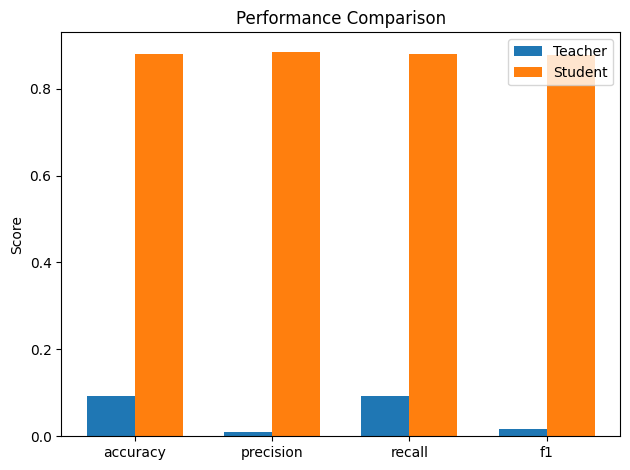

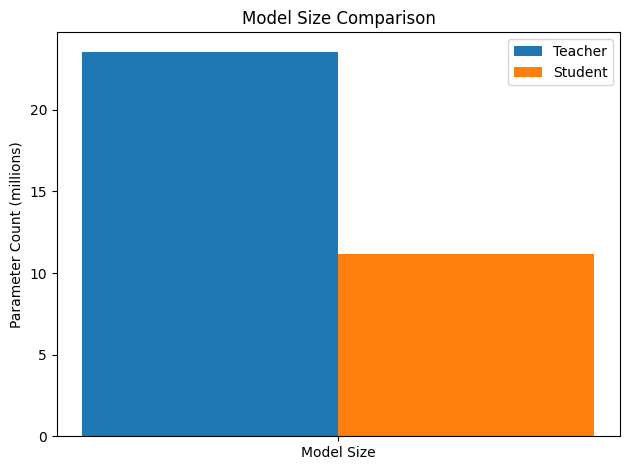

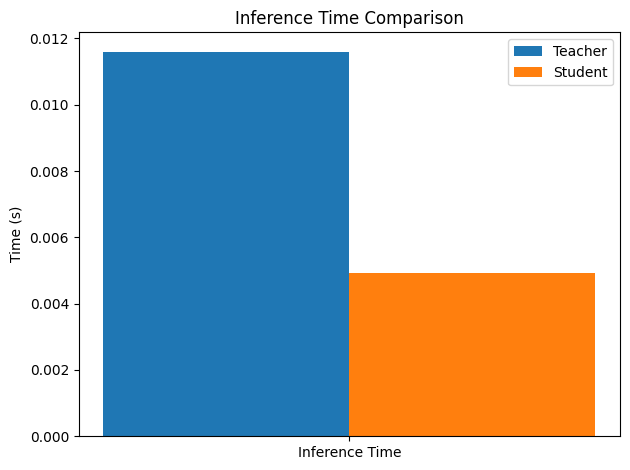

In [22]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

{'accuracy': (0.09221902017291066, 0.4040345821325648), 'precision': (0.008504347681651703, 0.41274801411558554), 'recall': (0.09221902017291066, 0.4040345821325648), 'f1': (0.015572604989620794, 0.39281734064573404)}


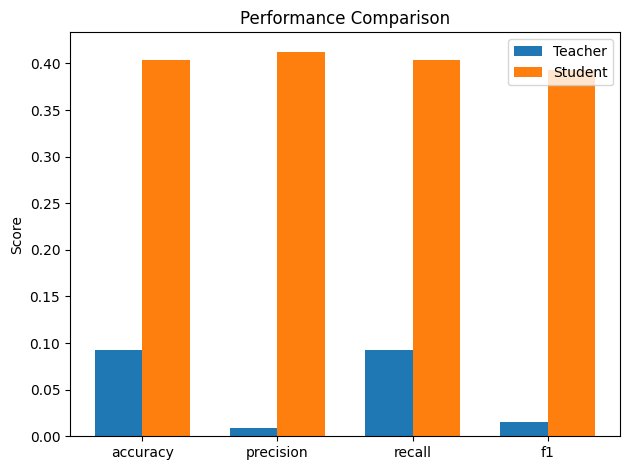

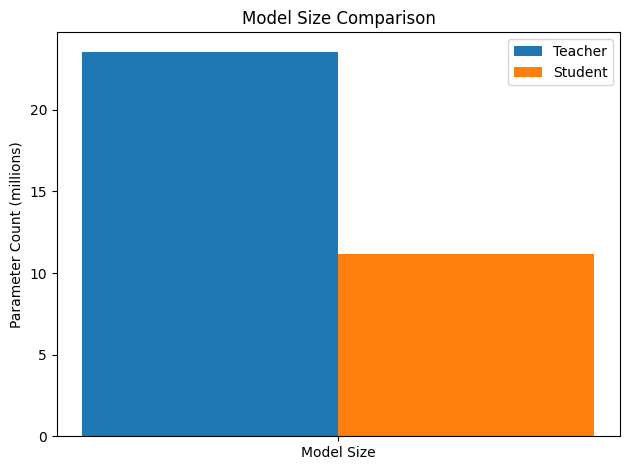

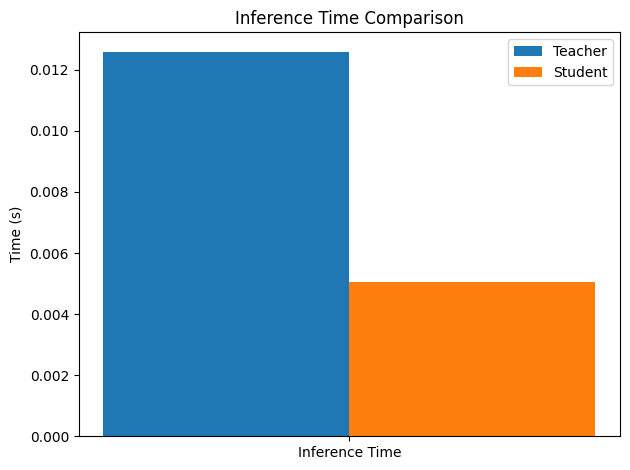

In [23]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')